# Feature Engineering
## Einfuehrung
## Exploration
## Transformation
## Konstruktion
## Selektion
## Implementation
## Nachträge

In [2]:
## prepare: import lbraries and set data path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

datapath = '../3_data'
from os import chdir; chdir(datapath)

#data = pd.read_csv('bank_data.csv', sep=';')

### NA imputation mit ML Methoden
#### Metrisch mit Regression: "age"

In [5]:
## preparations (minimal feature engineering)
data = pd.read_csv('bank_data.csv', sep=';')
data.drop(['default', 'pdays', 'poutcome'], axis=1, inplace=True)

## check before
na_idx = data.age.isna()
print(data.age[na_idx].head())

## remove rows with nas except for 'age'
s = data.isna().sum()
cols_with_nas = s[s > 0].index.tolist()
cols_with_nas.remove('age')
data.dropna(subset=cols_with_nas, inplace=True)

## one hot encoding all not nummerical Vars
data = pd.get_dummies(data)

## train - test - split 
##   train: data without NAs
##   test: data with NAs
nas = pd.isnull(data.age)
train = data[~nas]
test = data[nas]

## features - target - split
X_train = train.drop('age', axis=1)
y_train = train['age']
X_test = test.drop('age', axis=1)

## train model and predict values for NAs
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
y_test = model.predict(X_test)

## reconstruct data frame
train = train.assign(age = y_train)
test = test.assign(age = y_test)
new_data = pd.concat([train, test])

## check
print(new_data.age[na_idx].head())

7     NaN
20    NaN
34    NaN
101   NaN
327   NaN
Name: age, dtype: float64
7      62.270798
20     38.102409
34     41.409065
101    44.357099
327    39.134023
Name: age, dtype: float64


#### Kategorial mit Klassifikation: marital (obsolet)

In [7]:
## preparations (minimal feature engineering)
data = pd.read_csv('bank_data.csv', sep=';')
data.drop(['default', 'pdays', 'poutcome'], axis=1, inplace=True)

## check before
na_idx = data.marital.isna()
print(data.marital[na_idx].head())

## remove rows with nas except for 'marital'
s = data.isna().sum()
cols_with_nas = s[s > 0].index.tolist()
cols_with_nas.remove('marital')
data.dropna(subset=cols_with_nas, inplace=True)

## one hot encoding all not nummerical Vars except 'marital'
cat_vars = data.select_dtypes(include=['object']).columns.tolist()
cat_vars.remove('marital')
data = pd.get_dummies(data, columns=cat_vars)

## train - test - split
nas = pd.isnull(data.marital)
train = data[~nas]
test = data[nas]

## features - target - split
X_train = train.drop('marital', axis=1)
y_train = train['marital']
X_test = test.drop('marital', axis=1)

## train model and predict values for NAs
from sklearn.tree import DecisionTreeClassifier

#model = LinearRegression()
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_test = model.predict(X_test)

## reconstruct data frame
train = train.assign(marital = y_train)
test = test.assign(marital = y_test)
new_data = pd.concat([train, test])

## check
print(new_data.marital[na_idx].head())

553     NaN
1582    NaN
1698    NaN
1801    NaN
2274    NaN
Name: marital, dtype: object
553     married
1582    married
1698    married
1801     single
2274     single
Name: marital, dtype: object


#### `sklearn.impute.KNNImputer`

In [9]:
## preparations (minimal feature engineering)
data = pd.read_csv('bank_data.csv', sep=';')
data.drop(['default', 'pdays', 'poutcome'], axis=1)
data = pd.get_dummies(data)

## check before
na_idx = data.age.isna()
print(data.age[na_idx].head())

## use KNNImputer
from sklearn.impute import KNNImputer
imp = KNNImputer()
imp.fit(data)
new_data = pd.DataFrame(imp.transform(data), columns=data.columns)

## check after
print(new_data.age[na_idx].head())

7     NaN
20    NaN
34    NaN
101   NaN
327   NaN
Name: age, dtype: float64
7      36.0
20     30.4
34     52.8
101    43.8
327    41.4
Name: age, dtype: float64


#### sklearn.impute.IterativeImputer (EXTRA)

### Automatische Feature Selection mit ML Methoden
#### Modellbasierte Feature Selection
##### Klassifikationsmodelle

In [12]:
## preparations (minimal feature engineering)
data = pd.read_csv('bank_data.csv', sep=';')
data.drop(['default', 'pdays', 'poutcome'], axis=1)
data.dropna(inplace=True)

## features - target - split
X = data.drop('y', axis=1)
y = data['y']

## train - test - split
## not here

## one-hot encode X
X = pd.get_dummies(X)

## train a model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X, y)

## extract importance and feature names in a data frame
## and sort by descending importance
best = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})
best = best.sort_values(by=['importance'], ascending=False)
print(best.head(6))

         feature  importance
1       duration    0.218965
8      euribor3m    0.091758
3          pdays    0.063817
0            age    0.057058
7  cons.conf.idx    0.055135
9    nr.employed    0.053028


In [13]:
## use best 6 to filter
sel_vars = best.head(6).feature.tolist()
new_X = X[sel_vars]
print(new_X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1832 entries, 10 to 9867
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   duration       1832 non-null   float64
 1   euribor3m      1832 non-null   float64
 2   pdays          1832 non-null   int64  
 3   age            1832 non-null   float64
 4   cons.conf.idx  1832 non-null   float64
 5   nr.employed    1832 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 100.2 KB
None


##### Regressionsmodelle

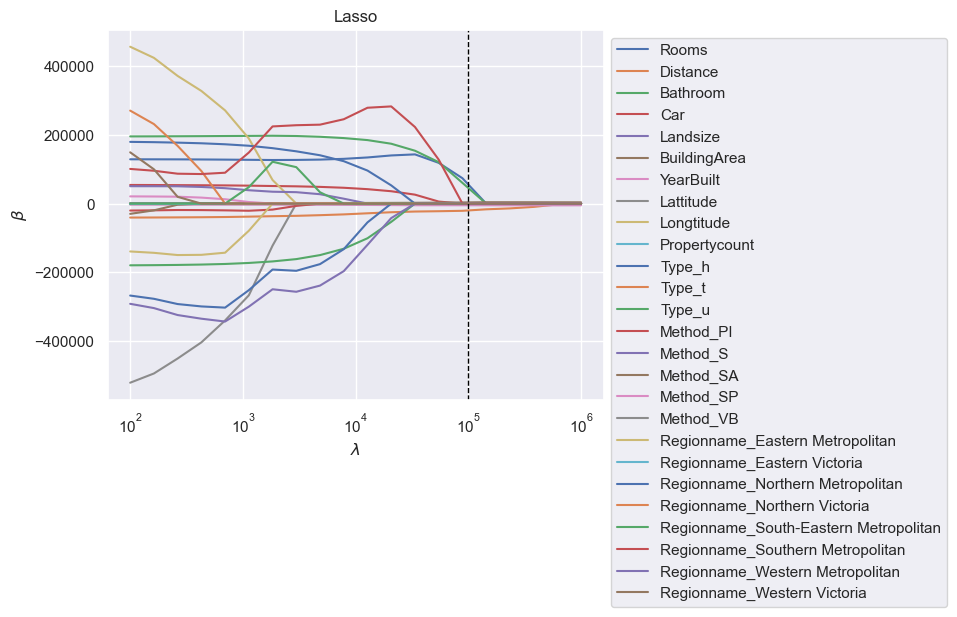

In [15]:
## preparations (minimal feature engineering)
data = pd.read_csv('melb_data.csv')
vars_to_drop = ['Unnamed: 0', 'Suburb', 'Address', 'SellerG', 'Postcode', 'Bedroom2', 'Date', 'CouncilArea']
data = data.drop(vars_to_drop, axis=1)
data.dropna(inplace=True)
data = pd.get_dummies(data)

X = data.drop('Price', axis=1)
y = data['Price']

## graph for  lasso
n_alphas = 20
alphas = np.logspace(2, 6, n_alphas)

from sklearn.linear_model import Lasso
coefs = []

for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X, y)
    coefs.append(model.coef_)

## Display results
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.axvline(x=1e5, color='black', linewidth=1.0, linestyle='dashed')
plt.title('Lasso')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\beta$')
plt.legend(X.columns, bbox_to_anchor=(1, 1));

In [16]:
## cut at 100000
model = Lasso(alpha=100000)
model.fit(X, y)

best = pd.DataFrame({
    'features': X.columns,
    'coefs': model.coef_
})

sel_vars = best[abs(best.coefs) > 0].features.tolist()
print(sel_vars)

['Rooms', 'Distance', 'Bathroom', 'Landsize', 'BuildingArea', 'YearBuilt', 'Propertycount']


In [17]:
new_X = X[sel_vars]

## check
new_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6830 entries, 1 to 18394
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          6830 non-null   int64  
 1   Distance       6830 non-null   float64
 2   Bathroom       6830 non-null   float64
 3   Landsize       6830 non-null   float64
 4   BuildingArea   6830 non-null   float64
 5   YearBuilt      6830 non-null   float64
 6   Propertycount  6830 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 426.9 KB


#### Iterative Methoden

##### RFE
Feature ranking with recursive feature elimination.

In [20]:
## preparations (minimal feature engineering)
data = pd.read_csv('bank_data.csv', sep=';')
data.dropna(inplace=True)
X = data.drop('y', axis=1)
y = data['y']
X = pd.get_dummies(X)

## train RFE with DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
select = RFE(DecisionTreeClassifier(random_state=1234),
             n_features_to_select=10)
select.fit(X, y)

## collect results as data frame
results = pd.DataFrame({
    'Feature' : X.columns,
    'Ranking' : select.ranking_,
    'Support' : select.support_}).\
        sort_values(by=['Ranking'], ascending = True)
print(results.head(6))

           Feature  Ranking  Support
0              age        1     True
1         duration        1     True
2         campaign        1     True
3            pdays        1     True
35     housing_yes        1     True
6   cons.price.idx        1     True


In [21]:
## filter selected features
sel_vars = results.Feature[results.Support==True].tolist()
print(sel_vars)
new_X = X[sel_vars]

## check
print(new_X.info())

['age', 'duration', 'campaign', 'pdays', 'housing_yes', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job_admin.']
<class 'pandas.core.frame.DataFrame'>
Index: 1832 entries, 10 to 9867
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1832 non-null   float64
 1   duration        1832 non-null   float64
 2   campaign        1832 non-null   int64  
 3   pdays           1832 non-null   int64  
 4   housing_yes     1832 non-null   bool   
 5   cons.price.idx  1832 non-null   float64
 6   cons.conf.idx   1832 non-null   float64
 7   euribor3m       1832 non-null   float64
 8   nr.employed     1832 non-null   float64
 9   job_admin.      1832 non-null   bool   
dtypes: bool(2), float64(6), int64(2)
memory usage: 132.4 KB
None


##### permutation_importance

In [23]:
## preparations (minimal feature engineering)
data = pd.read_csv('bank_data.csv', sep=';')
data.dropna(inplace=True)
X = data.drop('y', axis=1)
y = data['y']
X = pd.get_dummies(X)

In [24]:
## define trainer
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier().fit(X, y)

## permute features
from sklearn.inspection import permutation_importance
result = permutation_importance(
    model, X, y, 
    n_jobs=-1)

In [25]:
## collect results in a dataframe, ordered by mean
results_df = pd.DataFrame({
    'feature': X.columns,
    'mean': result.importances_mean,
    'std': result.importances_std
})
results_df = results_df.sort_values(by=['mean'], ascending=False)
print(results_df.head())

          feature      mean       std
1        duration  0.134498  0.005104
3           pdays  0.038428  0.003548
8       euribor3m  0.020524  0.000887
0             age  0.012445  0.001705
6  cons.price.idx  0.007969  0.002117


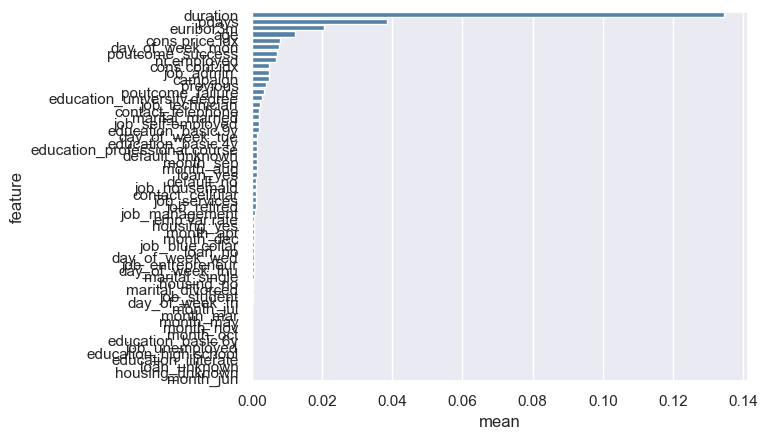

In [26]:
## visualize results
sns.barplot(x='mean', y='feature', data=results_df, color='steelblue');

In [27]:
## filter selected features
sel_vars = results_df.feature.head(10).tolist()
print(sel_vars)

#X_new = X[sel_vars]
#X_new.info()

['duration', 'pdays', 'euribor3m', 'age', 'cons.price.idx', 'day_of_week_mon', 'poutcome_success', 'nr.employed', 'cons.conf.idx', 'job_admin.']


### Feature Selektion mit PCA EXTRA
#### Korrelationen mit erster Hauptkomponente

euribor3m            0.903006
emp.var.rate         0.901418
nr.employed          0.846325
cons.price.idx       0.677601
contact_cellular     0.660243
contact_telephone    0.660243
Name: pc1, dtype: float64
5 best features : ['euribor3m', 'emp.var.rate', 'nr.employed', 'cons.price.idx', 'contact_cellular']


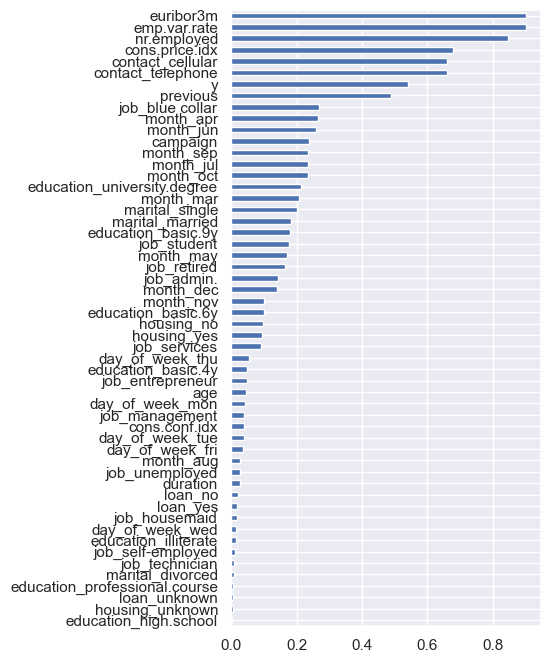

In [29]:
## preparations (minimal feature engineering)
data = pd.read_csv('bank_data.csv', sep=';')
data.drop(['default', 'pdays', 'poutcome'], axis=1, inplace=True)
data.dropna(inplace=True)

## recode target binnary
data.y = np.where(data.y == 'no', 0, 1)

## one-hot encode
data = pd.get_dummies(data)

## scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data), columns=data.columns)

## pca
from sklearn.decomposition import PCA
pca_1 = PCA(1)
pca_model = pca_1.fit_transform(data)

## add pc 1 to features
data['pc1'] = pca_model[:, 0]

## calculate correlation and keep absolute values
corr_df = abs(data.corr())

## order descending by by pc1
corr_df = corr_df.sort_values(by=['pc1'], ascending=False)
#print(corr_df)

## remove row pc1
corr_df = corr_df[1:]
#print(corr_df)

## show features and correlations
print(corr_df.pc1.head(6))

## plot
plt.figure(figsize=(4, 8))
corr_df.sort_values(by=['pc1'], ascending=True).pc1.plot(kind='barh');

## select 5 best (without pc1)
selected = corr_df['pc1'].iloc[:5].axes[0].tolist()
print('5 best features :', selected)

## opt reduce feature set
#data_red = data.loc[:, selected]
#data_red.info()

#### Biplot aus der Library pca